**Magnification Independent Binary Classification of BreakHis using SVM**

In [ ]:
from google.colab import drive                        # Mounting Colab to drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing all the Necessary Libraries
import math
import os

import cv2                                              
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications import ResNet50,MobileNet, DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
from functools import partial
from sklearn import metrics
import itertools
import h5py


%matplotlib inline

**Data Loading Function**

In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png" or ".tif":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG


Loading Benign images in a Numpy array

Loading images from each path by going into the directories and making them a numpy array.

In [ ]:
types = os.listdir('/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB')
print(types)
for i in range(len(types)):
  cases_path = '/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/'+types[i]
  print(cases_path)
  cases = os.listdir(cases_path)
  print(cases)
  for j in range(len(cases)):
    magnification_path = '/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/'+types[i]+'/'+cases[j]
    print(magnification_path)
    magnifications = os.listdir(magnification_path)
    print(magnifications)
    for k in range(len(magnifications)): 
      path = '/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/'+types[i]+'/'+cases[j]+'/'+magnifications[k]
      print(path)
      if k==0:
        benign = np.array(Dataset_loader(path, 128))              # Give the pixel count according to the Network being used.
      else:
        x = np.array(Dataset_loader(path, 128))
        benign = np.concatenate((benign,x),axis=0)
      print(len(benign))
    if j==0:
      benign_all = benign
    else:
      benign_all = np.concatenate((benign_all,benign),axis=0)
    print(len(benign_all))
  if i==0:
      total_benign = benign_all
  else:
      total_benign = np.concatenate((total_benign,benign_all),axis=0)
print(len(total_benign))

['fibroadenoma', 'tubular_adenoma', 'adenosis', 'phyllodes_tumor']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma
['SOB_B_F_14-25197', 'SOB_B_F_14-23222AB', 'SOB_B_F_14-29960AB', 'SOB_B_F_14-9133', 'SOB_B_F_14-23060AB', 'SOB_B_F_14-23060CD', 'SOB_B_F_14-21998CD', 'SOB_B_F_14-21998EF', 'SOB_B_F_14-14134E', 'SOB_B_F_14-14134']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197
['400X', '40X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X


100%|██████████| 33/33 [00:08<00:00,  3.76it/s]


33
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/40X


100%|██████████| 22/22 [00:06<00:00,  3.16it/s]


55
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X


100%|██████████| 32/32 [00:09<00:00,  3.41it/s]


87
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X


100%|██████████| 33/33 [00:09<00:00,  3.55it/s]


120
120
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB
['100X', '40X', '400X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/100X


100%|██████████| 16/16 [00:05<00:00,  2.96it/s]


16
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/40X


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


33
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/400X


100%|██████████| 18/18 [00:04<00:00,  3.73it/s]


51
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/200X


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


68
188
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB
['400X', '40X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/400X


100%|██████████| 17/17 [00:05<00:00,  3.34it/s]


17
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/40X


100%|██████████| 18/18 [00:09<00:00,  2.00it/s]


35
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/100X


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


50
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/200X


100%|██████████| 18/18 [00:06<00:00,  2.86it/s]


68
256
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133
['40X', '400X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/40X


100%|██████████| 26/26 [00:08<00:00,  2.94it/s]


26
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X


100%|██████████| 26/26 [00:06<00:00,  3.78it/s]


52
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X


100%|██████████| 36/36 [00:10<00:00,  3.46it/s]


88
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/200X


100%|██████████| 38/38 [00:12<00:00,  3.08it/s]


126
382
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB
['40X', '400X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/40X


100%|██████████| 23/23 [00:09<00:00,  2.45it/s]


23
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/400X


100%|██████████| 18/18 [00:05<00:00,  3.28it/s]


41
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/100X


100%|██████████| 22/22 [00:07<00:00,  2.98it/s]


63
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/200X


100%|██████████| 18/18 [00:05<00:00,  3.23it/s]


81
463
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD
['400X', '40X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/400X


100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


16
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/40X


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


30
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/200X


100%|██████████| 16/16 [00:06<00:00,  2.62it/s]


46
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/100X


100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


57
520
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD
['100X', '200X', '400X', '40X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X


100%|██████████| 31/31 [00:10<00:00,  3.08it/s]


31
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X


100%|██████████| 37/37 [00:10<00:00,  3.70it/s]


68
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X


100%|██████████| 32/32 [00:09<00:00,  3.53it/s]


100
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X


100%|██████████| 37/37 [00:10<00:00,  3.37it/s]


137
657
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF
['200X', '100X', '400X', '40X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/200X


100%|██████████| 29/29 [00:08<00:00,  3.32it/s]


29
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X


100%|██████████| 33/33 [00:10<00:00,  3.22it/s]


62
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X


100%|██████████| 28/28 [00:07<00:00,  3.76it/s]


90
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/40X


100%|██████████| 31/31 [00:09<00:00,  3.39it/s]


121
778
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E
['400X', '40X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/400X


100%|██████████| 12/12 [00:03<00:00,  3.51it/s]


12
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/40X


100%|██████████| 29/29 [00:07<00:00,  3.66it/s]


41
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X


100%|██████████| 32/32 [00:10<00:00,  3.01it/s]


73
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/200X


100%|██████████| 21/21 [00:05<00:00,  3.50it/s]


94
872
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134
['400X', '40X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X


100%|██████████| 37/37 [00:11<00:00,  3.29it/s]


37
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X


100%|██████████| 36/36 [00:09<00:00,  3.76it/s]


73
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/100X


100%|██████████| 31/31 [00:08<00:00,  3.66it/s]


104
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X


100%|██████████| 38/38 [00:09<00:00,  3.98it/s]


142
1014
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma
['SOB_B_TA_14-19854C', 'SOB_B_TA_14-21978AB', 'SOB_B_TA_14-16184CD', 'SOB_B_TA_14-3411F', 'SOB_B_TA_14-16184', 'SOB_B_TA_14-15275', 'SOB_B_TA_14-13200']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C
['40X', '400X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/40X


100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


16
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/400X


100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


32
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/100X


100%|██████████| 16/16 [00:05<00:00,  2.94it/s]


48
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/200X


100%|██████████| 16/16 [00:05<00:00,  2.68it/s]


64
64
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB
['100X', '200X', '40X', '400X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/100X


100%|██████████| 18/18 [00:05<00:00,  3.30it/s]


18
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/200X


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


35
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/40X


100%|██████████| 16/16 [00:05<00:00,  3.06it/s]


51
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/400X


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


65
129
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD
['40X', '100X', '400X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/40X


100%|██████████| 35/35 [00:11<00:00,  3.01it/s]


35
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/100X


100%|██████████| 37/37 [00:10<00:00,  3.66it/s]


72
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X


100%|██████████| 29/29 [00:08<00:00,  3.30it/s]


101
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/200X


100%|██████████| 23/23 [00:07<00:00,  3.06it/s]


124
253
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F
['400X', '40X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/400X


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


17
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/40X


100%|██████████| 16/16 [00:05<00:00,  2.78it/s]


33
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/200X


100%|██████████| 16/16 [00:05<00:00,  3.11it/s]


49
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/100X


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]


66
319
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184
['40X', '400X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X


100%|██████████| 39/39 [00:12<00:00,  3.24it/s]


39
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/400X


100%|██████████| 24/24 [00:06<00:00,  3.71it/s]


63
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X


100%|██████████| 34/34 [00:11<00:00,  2.89it/s]


97
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X


100%|██████████| 35/35 [00:10<00:00,  3.32it/s]


132
451
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275
['200X', '100X', '400X', '40X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/200X


100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


12
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/100X


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


26
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/400X


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


41
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/40X


100%|██████████| 12/12 [00:04<00:00,  2.93it/s]


53
504
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200
['200X', '100X', '40X', '400X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/200X


100%|██████████| 21/21 [00:05<00:00,  3.66it/s]


21
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/100X


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


35
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/40X


100%|██████████| 15/15 [00:04<00:00,  3.15it/s]


50
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/400X


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


65
569
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis
['SOB_B_A_14-22549CD', 'SOB_B_A_14-29960CD', 'SOB_B_A_14-22549AB', 'SOB_B_A_14-22549G']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD
['40X', '400X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X


100%|██████████| 35/35 [00:09<00:00,  3.58it/s]


35
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X


100%|██████████| 30/30 [00:08<00:00,  3.48it/s]


65
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X


100%|██████████| 36/36 [00:10<00:00,  3.58it/s]


101
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X


100%|██████████| 31/31 [00:08<00:00,  3.51it/s]


132
132
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD
['400X', '200X', '40X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/400X


100%|██████████| 17/17 [00:05<00:00,  3.35it/s]


17
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X


100%|██████████| 16/16 [00:03<00:00,  4.00it/s]


33
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/40X


100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


48
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/100X


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


61
193
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB
['40X', '100X', '400X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X


100%|██████████| 29/29 [00:08<00:00,  3.28it/s]


29
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X


100%|██████████| 30/30 [00:07<00:00,  3.82it/s]


59
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X


100%|██████████| 30/30 [00:08<00:00,  3.34it/s]


89
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X


100%|██████████| 32/32 [00:10<00:00,  3.01it/s]


121
314
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G
['40X', '400X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X


100%|██████████| 35/35 [00:11<00:00,  3.16it/s]


35
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/400X


100%|██████████| 29/29 [00:07<00:00,  3.63it/s]


64
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X


100%|██████████| 32/32 [00:09<00:00,  3.46it/s]


96
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X


100%|██████████| 34/34 [00:09<00:00,  3.59it/s]


130
444
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor
['SOB_B_PT_14-29315EF', 'SOB_B_PT_14-21998AB', 'SOB_B_PT_14-22704']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF
['40X', '400X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/40X


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


13
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/400X


100%|██████████| 17/17 [00:04<00:00,  3.40it/s]


30
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/100X


100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


46
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/200X


100%|██████████| 14/14 [00:04<00:00,  3.45it/s]


60
60
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB
['400X', '40X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X


100%|██████████| 59/59 [00:17<00:00,  3.30it/s]


59
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X


100%|██████████| 58/58 [00:18<00:00,  3.13it/s]


117
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X


100%|██████████| 66/66 [00:19<00:00,  3.40it/s]


183
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X


100%|██████████| 52/52 [00:15<00:00,  3.32it/s]


235
295
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704
['40X', '400X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


38
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X


100%|██████████| 39/39 [00:10<00:00,  3.58it/s]


77
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/200X


100%|██████████| 42/42 [00:11<00:00,  3.71it/s]


119
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X


100%|██████████| 39/39 [00:11<00:00,  3.50it/s]

158
453
2480


In [ ]:
types = os.listdir('/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB')
print(types)
for i in range(len(types)):
  cases_path = '/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/'+types[i]
  print(cases_path)
  cases = os.listdir(cases_path)
  print(cases)
  for j in range(len(cases)):
    magnification_path = '/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/'+types[i]+'/'+cases[j]
    print(magnification_path)
    magnifications = os.listdir(magnification_path)
    print(magnifications)
    for k in range(len(magnifications)): 
      path = '/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/'+types[i]+'/'+cases[j]+'/'+magnifications[k]
      print(path)
      if k==0:
        malignant = np.array(Dataset_loader(path, 128))                   # Give the pixel count according to the Network being used.
      else:
        x = np.array(Dataset_loader(path, 128))
        malignant = np.concatenate((malignant,x),axis=0)
      print(len(malignant))
    if j==0:
      malignant_all = malignant
    else:
      malignant_all = np.concatenate((malignant_all,malignant),axis=0)
    print(len(malignant_all))
  if i==0:
      total_malignant = malignant_all
  else:
      total_malignant = np.concatenate((total_malignant,malignant_all),axis=0)
print(len(total_malignant))

['papillary_carcinoma', 'mucinous_carcinoma', 'ductal_carcinoma', 'lobular_carcinoma']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma
['SOB_M_PC_15-190EF', 'SOB_M_PC_14-9146', 'SOB_M_PC_14-15704', 'SOB_M_PC_14-12465', 'SOB_M_PC_14-19440', 'SOB_M_PC_14-15687B']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF
['40X', '400X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/40X


100%|██████████| 19/19 [00:06<00:00,  2.82it/s]


19
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/400X


100%|██████████| 15/15 [00:04<00:00,  3.28it/s]


34
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/100X


100%|██████████| 16/16 [00:04<00:00,  3.52it/s]


50
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/200X


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


65
65
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146
['40X', '400X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X


100%|██████████| 23/23 [00:06<00:00,  3.35it/s]


23
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X


100%|██████████| 24/24 [00:06<00:00,  3.61it/s]


47
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/100X


100%|██████████| 22/22 [00:06<00:00,  3.26it/s]


69
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


90
155
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704
['40X', '400X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/40X


100%|██████████| 30/30 [00:09<00:00,  3.26it/s]


30
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/400X


100%|██████████| 35/35 [00:09<00:00,  3.51it/s]


65
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X


100%|██████████| 33/33 [00:10<00:00,  3.29it/s]


98
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/100X


100%|██████████| 29/29 [00:07<00:00,  3.69it/s]


127
282
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-12465
['40X', '400X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-12465/40X


100%|██████████| 21/21 [00:06<00:00,  3.00it/s]


21
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-12465/400X


100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


34
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-12465/100X


100%|██████████| 21/21 [00:08<00:00,  2.43it/s]


55
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-12465/200X


100%|██████████| 19/19 [00:05<00:00,  3.49it/s]


74
356
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440
['400X', '40X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X


100%|██████████| 36/36 [00:11<00:00,  3.17it/s]


36
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X


100%|██████████| 35/35 [00:10<00:00,  3.50it/s]


71
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X


100%|██████████| 33/33 [00:10<00:00,  3.07it/s]


104
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X


100%|██████████| 38/38 [00:10<00:00,  3.51it/s]


142
498
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B
['40X', '100X', '200X', '400X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/40X


100%|██████████| 17/17 [00:05<00:00,  3.29it/s]


17
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/100X


100%|██████████| 16/16 [00:04<00:00,  3.71it/s]


33
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/200X


100%|██████████| 14/14 [00:04<00:00,  3.30it/s]


47
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/400X


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


62
560
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma
['SOB_M_MC_14-19979C', 'SOB_M_MC_14-19979', 'SOB_M_MC_14-18842D', 'SOB_M_MC_14-18842', 'SOB_M_MC_14-16456', 'SOB_M_MC_14-13418DE', 'SOB_M_MC_14-13413', 'SOB_M_MC_14-12773', 'SOB_M_MC_14-10147']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C
['400X', '40X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/400X


100%|██████████| 15/15 [00:04<00:00,  3.27it/s]


15
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/40X


100%|██████████| 17/17 [00:25<00:00,  1.51s/it]


32
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/200X


100%|██████████| 16/16 [00:05<00:00,  2.90it/s]


48
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/100X


100%|██████████| 14/14 [00:03<00:00,  3.56it/s]


62
62
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979
['40X', '200X', '400X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/40X


100%|██████████| 26/26 [00:07<00:00,  3.39it/s]


26
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/200X


100%|██████████| 21/21 [00:06<00:00,  3.09it/s]


47
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/400X


100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


71
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X


100%|██████████| 27/27 [00:06<00:00,  3.99it/s]


98
160
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D
['400X', '40X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/400X


100%|██████████| 16/16 [00:05<00:00,  2.90it/s]


16
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/40X


100%|██████████| 16/16 [00:05<00:00,  3.10it/s]


32
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/100X


100%|██████████| 16/16 [00:04<00:00,  3.88it/s]


48
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/200X


100%|██████████| 16/16 [00:04<00:00,  3.53it/s]


64
224
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842
['400X', '40X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/400X


100%|██████████| 9/9 [00:02<00:00,  3.62it/s]


9
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/40X


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


24
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/200X


100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


40
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/100X


100%|██████████| 22/22 [00:06<00:00,  3.40it/s]


62
286
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456
['40X', '400X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X


100%|██████████| 46/46 [00:15<00:00,  3.02it/s]


46
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/400X


100%|██████████| 35/35 [00:09<00:00,  3.78it/s]


81
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X


100%|██████████| 47/47 [00:12<00:00,  3.63it/s]


128
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X


100%|██████████| 50/50 [00:12<00:00,  3.95it/s]


178
464
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE
['200X', '40X', '100X', '400X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/200X


100%|██████████| 14/14 [00:04<00:00,  3.03it/s]


14
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/40X


100%|██████████| 15/15 [00:04<00:00,  3.29it/s]


29
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/100X


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


44
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/400X


100%|██████████| 11/11 [00:03<00:00,  3.57it/s]


55
519
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413
['40X', '400X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/40X


100%|██████████| 29/29 [00:08<00:00,  3.50it/s]


29
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/400X


100%|██████████| 26/26 [00:06<00:00,  3.81it/s]


55
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X


100%|██████████| 41/41 [00:12<00:00,  3.36it/s]


96
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/200X


100%|██████████| 23/23 [00:06<00:00,  3.67it/s]


119
638
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773
['40X', '400X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/40X


100%|██████████| 26/26 [00:07<00:00,  3.44it/s]


26
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/400X


100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


44
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/200X


100%|██████████| 21/21 [00:05<00:00,  3.76it/s]


65
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/100X


100%|██████████| 25/25 [00:06<00:00,  3.79it/s]


90
728
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147
['100X', '40X', '400X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/100X


100%|██████████| 12/12 [00:03<00:00,  3.59it/s]


12
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/40X


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


27
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/400X


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


42
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/200X


100%|██████████| 22/22 [00:06<00:00,  3.22it/s]


64
792
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma
['SOB_M_DC_14-8168', 'SOB_M_DC_14-9461', 'SOB_M_DC_14-5695', 'SOB_M_DC_14-6241', 'SOB_M_DC_14-5287', 'SOB_M_DC_14-5694', 'SOB_M_DC_14-4364', 'SOB_M_DC_14-2773', 'SOB_M_DC_14-4372', 'SOB_M_DC_14-3909', 'SOB_M_DC_14-2985', 'SOB_M_DC_14-2980', 'SOB_M_DC_14-2523', 'SOB_M_DC_14-20636', 'SOB_M_DC_14-18650', 'SOB_M_DC_14-20629', 'SOB_M_DC_14-17915', 'SOB_M_DC_14-17901', 'SOB_M_DC_14-16875', 'SOB_M_DC_14-16601', 'SOB_M_DC_14-16716', 'SOB_M_DC_14-17614', 'SOB_M_DC_14-16448', 'SOB_M_DC_14-16336', 'SOB_M_DC_14-15792', 'SOB_M_DC_14-16188', 'SOB_M_DC_14-14946', 'SOB_M_DC_14-13993', 'SOB_M_DC_14-15572', 'SOB_M_DC_14-14926', 'SOB_M_DC_14-15696', 'SOB_M_DC_14-14015', 'SOB_M_DC_14-12312', 'SOB_M_DC_14-13412', 'SOB_M_DC_14-11951', 'SOB_M_DC_14-11520', 'SOB_M_DC_14-10926', 'SOB_M_DC_14-11031']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_

100%|██████████| 9/9 [00:03<00:00,  2.66it/s]


9
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/40X


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


19
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/100X


100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


29
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/200X


100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


38
38
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461
['400X', '100X', '40X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/400X


100%|██████████| 31/31 [00:08<00:00,  3.51it/s]


31
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X


100%|██████████| 36/36 [00:09<00:00,  3.61it/s]


67
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/40X


100%|██████████| 26/26 [00:09<00:00,  2.72it/s]


93
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X


100%|██████████| 62/62 [00:18<00:00,  3.31it/s]


155
193
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695
['40X', '200X', '400X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X


100%|██████████| 23/23 [00:06<00:00,  3.60it/s]


23
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/200X


100%|██████████| 22/22 [00:06<00:00,  3.19it/s]


45
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/400X


100%|██████████| 24/24 [00:06<00:00,  3.63it/s]


69
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/100X


100%|██████████| 21/21 [00:07<00:00,  2.81it/s]


90
283
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241
['400X', '40X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/400X


100%|██████████| 13/13 [00:03<00:00,  3.38it/s]


13
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X


100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


45
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X


100%|██████████| 21/21 [00:06<00:00,  3.13it/s]


66
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/200X


100%|██████████| 12/12 [00:03<00:00,  3.54it/s]


78
361
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287
['400X', '100X', '200X', '40X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/400X


100%|██████████| 23/23 [00:06<00:00,  3.51it/s]


23
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/100X


100%|██████████| 21/21 [00:05<00:00,  4.00it/s]


44
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/200X


100%|██████████| 21/21 [00:05<00:00,  3.81it/s]


65
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/40X


100%|██████████| 23/23 [00:07<00:00,  3.13it/s]


88
449
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694
['40X', '400X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X


100%|██████████| 22/22 [00:05<00:00,  3.73it/s]


22
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X


100%|██████████| 26/26 [00:06<00:00,  3.76it/s]


48
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/200X


100%|██████████| 21/21 [00:05<00:00,  3.84it/s]


69
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/100X


100%|██████████| 21/21 [00:05<00:00,  4.09it/s]


90
539
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364
['40X', '400X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/40X


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


1
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/400X


100%|██████████| 8/8 [00:02<00:00,  3.31it/s]


9
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/200X


100%|██████████| 25/25 [00:07<00:00,  3.46it/s]


34
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/100X


100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


44
583
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773
['400X', '40X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X


100%|██████████| 38/38 [00:10<00:00,  3.52it/s]


38
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/40X


100%|██████████| 30/30 [00:08<00:00,  3.49it/s]


68
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X


100%|██████████| 35/35 [00:09<00:00,  3.52it/s]


103
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/100X


100%|██████████| 41/41 [00:11<00:00,  3.58it/s]


144
727
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372
['40X', '400X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/40X


100%|██████████| 21/21 [00:06<00:00,  3.39it/s]


21
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/400X


100%|██████████| 24/24 [00:06<00:00,  3.72it/s]


45
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X


100%|██████████| 22/22 [00:05<00:00,  3.79it/s]


67
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/200X


100%|██████████| 17/17 [00:04<00:00,  3.46it/s]


84
811
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909
['40X', '400X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/40X


100%|██████████| 26/26 [00:06<00:00,  3.85it/s]


26
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/400X


100%|██████████| 14/14 [00:03<00:00,  3.59it/s]


40
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/100X


100%|██████████| 26/26 [00:07<00:00,  3.50it/s]


66
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X


100%|██████████| 29/29 [00:07<00:00,  3.74it/s]


95
906
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985
['100X', '40X', '400X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/100X


100%|██████████| 11/11 [00:02<00:00,  3.87it/s]


11
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/40X


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


31
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/400X


100%|██████████| 14/14 [00:03<00:00,  3.50it/s]


45
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/200X


100%|██████████| 14/14 [00:03<00:00,  3.74it/s]


59
965
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980
['40X', '400X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/40X


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


20
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/400X


100%|██████████| 18/18 [00:05<00:00,  3.46it/s]


38
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X


100%|██████████| 25/25 [00:07<00:00,  3.52it/s]


63
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/200X


100%|██████████| 21/21 [00:06<00:00,  3.25it/s]


84
1049
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523
['200X', '400X', '100X', '40X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/200X


100%|██████████| 18/18 [00:05<00:00,  3.54it/s]


18
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/400X


100%|██████████| 24/24 [00:06<00:00,  3.57it/s]


42
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/100X


100%|██████████| 23/23 [00:05<00:00,  4.23it/s]


65
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/40X


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


75
1124
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636
['40X', '400X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/40X


100%|██████████| 25/25 [00:07<00:00,  3.51it/s]


25
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/400X


100%|██████████| 22/22 [00:05<00:00,  3.88it/s]


47
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/200X


100%|██████████| 27/27 [00:07<00:00,  3.64it/s]


74
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X


100%|██████████| 37/37 [00:09<00:00,  3.71it/s]


111
1235
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650
['400X', '40X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X


100%|██████████| 29/29 [00:08<00:00,  3.56it/s]


29
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/40X


100%|██████████| 29/29 [00:09<00:00,  2.95it/s]


58
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/200X


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


86
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/100X


100%|██████████| 22/22 [00:06<00:00,  3.32it/s]


108
1343
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629
['400X', '40X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X


100%|██████████| 24/24 [00:06<00:00,  3.94it/s]


24
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X


100%|██████████| 36/36 [00:10<00:00,  3.31it/s]


60
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/200X


100%|██████████| 32/32 [00:09<00:00,  3.41it/s]


92
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X


100%|██████████| 33/33 [00:08<00:00,  3.79it/s]


125
1468
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915
['40X', '400X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/40X


100%|██████████| 26/26 [00:07<00:00,  3.51it/s]


26
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/400X


100%|██████████| 16/16 [00:04<00:00,  3.63it/s]


42
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/200X


100%|██████████| 21/21 [00:06<00:00,  3.33it/s]


63
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/100X


100%|██████████| 16/16 [00:04<00:00,  3.91it/s]


79
1547
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901
['400X', '40X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/400X


100%|██████████| 28/28 [00:07<00:00,  3.90it/s]


28
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X


100%|██████████| 26/26 [00:06<00:00,  4.02it/s]


54
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/100X


100%|██████████| 26/26 [00:07<00:00,  3.52it/s]


80
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/200X


100%|██████████| 24/24 [00:06<00:00,  3.62it/s]


104
1651
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875
['400X', '40X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/400X


100%|██████████| 8/8 [00:02<00:00,  3.54it/s]


8
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/40X


100%|██████████| 14/14 [00:04<00:00,  3.43it/s]


22
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/200X


100%|██████████| 17/17 [00:04<00:00,  3.67it/s]


39
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/100X


100%|██████████| 22/22 [00:05<00:00,  4.31it/s]


61
1712
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601
['40X', '100X', '200X', '400X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/40X


100%|██████████| 12/12 [00:03<00:00,  3.46it/s]


12
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/100X


100%|██████████| 10/10 [00:02<00:00,  4.45it/s]


22
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/200X


100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


32
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/400X


100%|██████████| 13/13 [00:03<00:00,  3.44it/s]


45
1757
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716
['400X', '40X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/400X


100%|██████████| 29/29 [00:07<00:00,  3.77it/s]


29
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X


100%|██████████| 38/38 [00:12<00:00,  2.95it/s]


67
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X


100%|██████████| 34/34 [00:09<00:00,  3.62it/s]


101
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X


100%|██████████| 36/36 [00:10<00:00,  3.40it/s]


137
1894
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614
['400X', '200X', '100X', '40X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/400X


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


28
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/200X


100%|██████████| 33/33 [00:09<00:00,  3.62it/s]


61
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/100X


100%|██████████| 29/29 [00:07<00:00,  3.91it/s]


90
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X


100%|██████████| 39/39 [00:10<00:00,  3.63it/s]


129
2023
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448
['40X', '400X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/40X


100%|██████████| 11/11 [00:02<00:00,  3.72it/s]


11
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/400X


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


26
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/100X


100%|██████████| 14/14 [00:04<00:00,  3.20it/s]


40
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/200X


100%|██████████| 13/13 [00:03<00:00,  3.74it/s]


53
2076
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336
['400X', '100X', '40X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/400X


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


9
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/100X


100%|██████████| 19/19 [00:05<00:00,  3.32it/s]


28
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/40X


100%|██████████| 13/13 [00:03<00:00,  3.30it/s]


41
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/200X


100%|██████████| 19/19 [00:05<00:00,  3.63it/s]


60
2136
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792
['40X', '400X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/40X


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


14
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/400X


100%|██████████| 15/15 [00:04<00:00,  3.16it/s]


29
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/200X


100%|██████████| 12/12 [00:03<00:00,  3.57it/s]


41
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/100X


100%|██████████| 14/14 [00:03<00:00,  3.58it/s]


55
2191
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188
['400X', '40X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/400X


100%|██████████| 23/23 [00:06<00:00,  3.76it/s]


23
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/40X


100%|██████████| 24/24 [00:06<00:00,  3.64it/s]


47
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/100X


100%|██████████| 19/19 [00:05<00:00,  3.53it/s]


66
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/200X


100%|██████████| 21/21 [00:06<00:00,  3.47it/s]


87
2278
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946
['40X', '400X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X


100%|██████████| 31/31 [00:08<00:00,  3.71it/s]


31
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X


100%|██████████| 34/34 [00:09<00:00,  3.54it/s]


65
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/200X


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


99
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/100X


100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


131
2409
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993
['100X', '40X', '400X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X


100%|██████████| 42/42 [00:11<00:00,  3.50it/s]


42
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X


100%|██████████| 37/37 [00:10<00:00,  3.46it/s]


79
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X


100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


111
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X


100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


145
2554
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572
['40X', '400X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/40X


100%|██████████| 23/23 [00:06<00:00,  3.31it/s]


23
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/400X


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


38
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/100X


100%|██████████| 23/23 [00:06<00:00,  3.31it/s]


61
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/200X


100%|██████████| 19/19 [00:05<00:00,  3.17it/s]


80
2634
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926
['40X', '400X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/40X


100%|██████████| 20/20 [00:07<00:00,  2.84it/s]


20
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/400X


100%|██████████| 16/16 [00:03<00:00,  4.09it/s]


36
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/100X


100%|██████████| 19/19 [00:04<00:00,  3.92it/s]


55
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/200X


100%|██████████| 18/18 [00:05<00:00,  3.55it/s]


73
2707
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696
['40X', '400X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/40X


100%|██████████| 23/23 [00:07<00:00,  3.16it/s]


23
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/400X


100%|██████████| 15/15 [00:04<00:00,  3.29it/s]


38
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/200X


100%|██████████| 22/22 [00:05<00:00,  3.73it/s]


60
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/100X


100%|██████████| 23/23 [00:07<00:00,  3.25it/s]


83
2790
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015
['400X', '40X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/400X


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


20
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/40X


100%|██████████| 18/18 [00:05<00:00,  3.22it/s]


38
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/200X


100%|██████████| 30/30 [00:08<00:00,  3.43it/s]


68
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/100X


100%|██████████| 27/27 [00:07<00:00,  3.62it/s]


95
2885
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312
['40X', '400X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X


100%|██████████| 32/32 [00:09<00:00,  3.23it/s]


32
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X


100%|██████████| 38/38 [00:10<00:00,  3.67it/s]


70
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X


100%|██████████| 35/35 [00:10<00:00,  3.41it/s]


105
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X


100%|██████████| 41/41 [00:12<00:00,  3.38it/s]


146
3031
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13412
['40X', '100X', '400X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13412/40X


100%|██████████| 32/32 [00:09<00:00,  3.36it/s]


32
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13412/100X


100%|██████████| 33/33 [00:09<00:00,  3.48it/s]


65
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13412/400X


100%|██████████| 26/26 [00:07<00:00,  3.70it/s]


91
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13412/200X


100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


123
3154
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951
['400X', '40X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/400X


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


20
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/40X


100%|██████████| 27/27 [00:09<00:00,  2.81it/s]


47
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/200X


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


75
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/100X


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


100
3254
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520
['400X', '40X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/400X


100%|██████████| 23/23 [00:06<00:00,  3.65it/s]


23
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


48
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/100X


100%|██████████| 26/26 [00:07<00:00,  3.56it/s]


74
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X


100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


98
3352
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926
['400X', '40X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/400X


100%|██████████| 9/9 [00:02<00:00,  3.49it/s]


9
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/40X


100%|██████████| 11/11 [00:03<00:00,  3.39it/s]


20
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/200X


100%|██████████| 9/9 [00:02<00:00,  4.03it/s]


29
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


39
3391
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031
['40X', '400X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/40X


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


14
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/400X


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


29
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/100X


100%|██████████| 17/17 [00:05<00:00,  3.29it/s]


46
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/200X


100%|██████████| 14/14 [00:03<00:00,  3.58it/s]


60
3451
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma
['SOB_M_LC_14-16196', 'SOB_M_LC_14-15570C', 'SOB_M_LC_14-12204', 'SOB_M_LC_14-15570', 'SOB_M_LC_14-13412']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196
['40X', '400X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/40X


100%|██████████| 22/22 [00:05<00:00,  3.76it/s]


22
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/400X


100%|██████████| 17/17 [00:04<00:00,  3.85it/s]


39
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/100X


100%|██████████| 17/17 [00:04<00:00,  3.70it/s]


56
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/200X


100%|██████████| 18/18 [00:05<00:00,  3.53it/s]


74
74
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C
['400X', '40X', '100X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/400X


100%|██████████| 29/29 [00:08<00:00,  3.48it/s]


29
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X


100%|██████████| 31/31 [00:09<00:00,  3.33it/s]


60
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X


100%|██████████| 35/35 [00:10<00:00,  3.39it/s]


95
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/200X


100%|██████████| 30/30 [00:09<00:00,  3.01it/s]


125
199
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204
['40X', '400X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/40X


100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


20
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/400X


100%|██████████| 24/24 [00:05<00:00,  4.07it/s]


44
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200X


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


72
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X


100%|██████████| 31/31 [00:07<00:00,  4.03it/s]


103
302
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570
['40X', '100X', '400X', '200X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X


100%|██████████| 51/51 [00:14<00:00,  3.45it/s]


51
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X


100%|██████████| 54/54 [00:14<00:00,  3.76it/s]


105
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/400X


100%|██████████| 41/41 [00:11<00:00,  3.62it/s]


146
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X


100%|██████████| 55/55 [00:14<00:00,  3.87it/s]


201
503
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-13412
['400X', '40X', '200X', '100X']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-13412/400X


100%|██████████| 26/26 [00:06<00:00,  4.10it/s]


26
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-13412/40X


100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


58
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-13412/200X


100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


90
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-13412/100X


100%|██████████| 33/33 [00:07<00:00,  4.22it/s]


123
626
5429


In [ ]:
benign_label = np.zeros(len(total_benign))                         # Labelling Benign as '0' and Malignant as '1'
malignant_label = np.ones(len(total_malignant))

In [ ]:
x = np.concatenate((total_benign,total_malignant) ,axis=0)        # concatenating the benign and malignant image arrays
x=x/255
y = np.concatenate((benign_label,malignant_label) ,axis=0)        # concatenating the benign and malignant label arrays

In [ ]:
print(len(x))

7909


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3)         #Splitting the data as 70% in Train Set and 30% in Test Set.

In [ ]:
print(len(x_train),len(x_test))

5536 2373


In [ ]:
s=np.arange(x_train.shape[0])             # Shuffling the data
np.random.shuffle(s)
x_train=x_train[s]
y_train=y_train[s]

s=np.arange(x_test.shape[0])
np.random.shuffle(s)
x_test=x_test[s]
y_test=y_test[s]

y_train=to_categorical(y_train, num_classes=2)        # One hot encoding
y_test=to_categorical(y_test, num_classes=2)


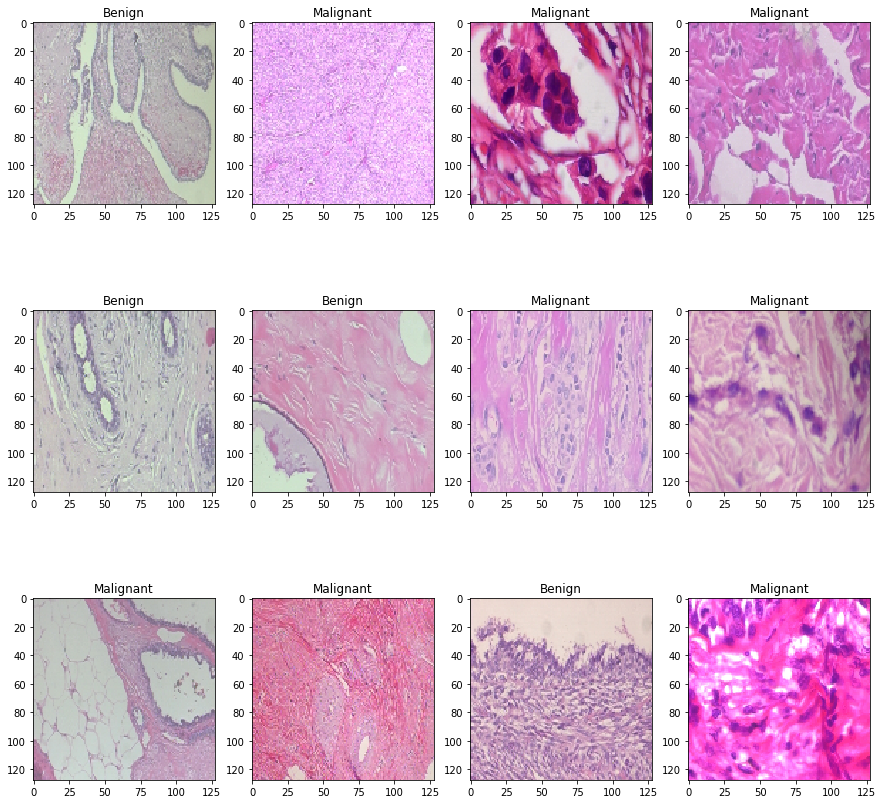

In [ ]:
# Displaying some images
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
        ax.title.set_text('Benign')    
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 16           # Batch Size

train_generator = ImageDataGenerator(             #Data Augmentation block
        zoom_range=2,  
        rotation_range = 90,
        horizontal_flip=True,
        vertical_flip=True,  
    )

In [ ]:
def build_model():                # Creating the Model
    model = Sequential()
    model.add(DenseNet201(weights='imagenet',include_top=False,input_shape=(128,128,3)))          #Give the input shape according to the Network to be used.
    model.add(layers.GlobalAveragePooling2D())                                                    #Change the name of the network accordingly.
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())

    
    model.add(layers.Dense(2,kernel_regularizer = regularizers.l2(0.01),activation = "linear"))
    
    
    model.compile(
        loss= "hinge",
        optimizer="adam",
        metrics=['accuracy']
    )
    
    return model

In [ ]:
model = build_model()         # Building the model
model.summary()

74850304/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________


In [ ]:
learn_control = ReduceLROnPlateau(monitor='accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="/content/drive/MyDrive/Project/Binary Classification/Magnification Independent/SVM/DenseNet/densenet_svm.h5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
#Training the Model
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    callbacks=[learn_control, checkpoint]
)

Epoch 1/50
346/346 [==============================] - 106s 306ms/step - loss: 0.2078 - accuracy: 0.9037

Epoch 00001: accuracy did not improve from 0.90824
Epoch 2/50
346/346 [==============================] - 106s 306ms/step - loss: 0.2237 - accuracy: 0.8958

Epoch 00002: accuracy did not improve from 0.90824
Epoch 3/50
346/346 [==============================] - 106s 305ms/step - loss: 0.2227 - accuracy: 0.8974

Epoch 00003: accuracy did not improve from 0.90824
Epoch 4/50
346/346 [==============================] - 106s 305ms/step - loss: 0.2009 - accuracy: 0.9086

Epoch 00004: accuracy improved from 0.90824 to 0.90860, saving model to /content/drive/MyDrive/Project/Binary Classification/Magnification Independent/SVM/DenseNet/densenet_svm.h5
Epoch 5/50
346/346 [==============================] - 106s 306ms/step - loss: 0.2222 - accuracy: 0.8974

Epoch 00005: accuracy did not improve from 0.90860
Epoch 6/50
346/346 [==============================] - 106s 306ms/step - loss: 0.2175 - accu

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'lr'])

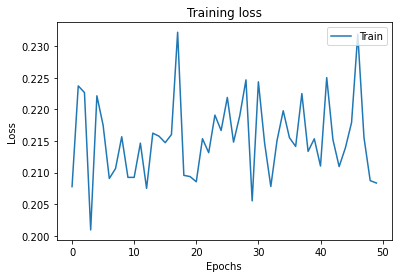

In [ ]:
plt.plot(history.history['loss'])
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train'],loc='upper right')
plt.show()

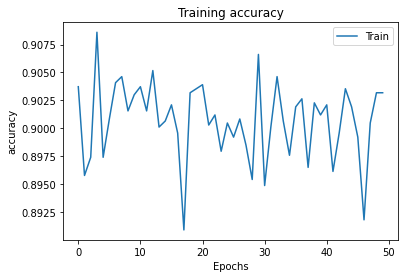

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Train'],loc='upper right')
plt.show()

In [ ]:
# making predictions using the trained model
Y_pred = model.predict(x_test)

In [ ]:
# Obtaining accuracy Score
accuracy_score(np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1))

0.9258322798145807

Confusion matrix, without normalization
[[ 699   80]
 [  96 1498]]


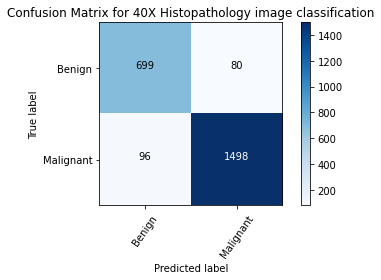

In [ ]:
# Plotting confusion matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Benign','Malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix for 40X Histopathology image classification')

In [ ]:
# Generating classification report
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(Y_pred,axis=1), target_names=cm_plot_label))

              precision    recall  f1-score   support

      Benign       0.88      0.90      0.89       779
   Malignant       0.95      0.94      0.94      1594

    accuracy                           0.93      2373
   macro avg       0.91      0.92      0.92      2373
weighted avg       0.93      0.93      0.93      2373



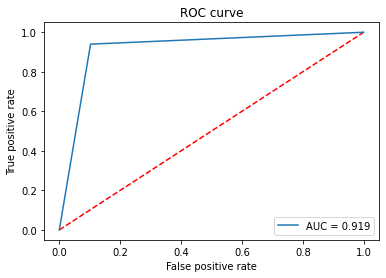

In [ ]:
#Plotting the ROc Curve
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()